In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json
Saving uresnet.py to uresnet.py


{'kaggle.json': b'{"username":"adityajn105","key":"74ac3c08ead73b4bb100dc52c557f763"}',
 'uresnet.py': b'from keras.layers import ZeroPadding2D, BatchNormalization, Conv2D, Activation, MaxPooling2D\nfrom keras.layers import UpSampling2D, Input, Conv2D, Conv2DTranspose, Add, Concatenate\nfrom keras.utils.data_utils import get_file\nfrom keras.models import Model\n\ndef handle_block_names_old(stage):\n    conv_name = \'decoder_stage{}_conv\'.format(stage)\n    bn_name = \'decoder_stage{}_bn\'.format(stage)\n    relu_name = \'decoder_stage{}_relu\'.format(stage)\n    up_name = \'decoder_stage{}_upsample\'.format(stage)\n    return conv_name, bn_name, relu_name, up_name\n\n\ndef up_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),transpose_kernel_size=(4,4), batchnorm=False, skip=None):\n    def layer(input_tensor):\n\n        conv_name, bn_name, relu_name, up_name = handle_block_names_old(stage)\n\n        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_ra

In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip -q train.zip
!unzip -q test.zip
!rm train.zip test.zip

### TGT Salt Classification Challenge


In [0]:
import numpy as np
import gc
import cv2
def rle_to_output(x):
  if type(x)!=np.float:
    x = list(map(int, x.split(' ')))
    out = np.zeros(101*101,dtype=np.int64)
    for i in range(0,len(x),2):
      out[ x[i]-1:x[i+1]+x[i]-1 ] = 1
    return np.reshape(np.array(out),(101,101)).T
  else:
    return np.zeros((128,128),dtype=np.int64)

In [2]:
import glob
import pandas as pd

data = pd.read_csv('train.csv')
depths = pd.read_csv('depths.csv')
data = pd.merge(data,depths,on='id',how='left')
X = data.id.apply(lambda x: "images/"+str(x)+'.png')
Y = data.id.apply(lambda x: "masks/"+str(x)+'.png')
Z = data.z
data.head(5)

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


### Basic Visualization

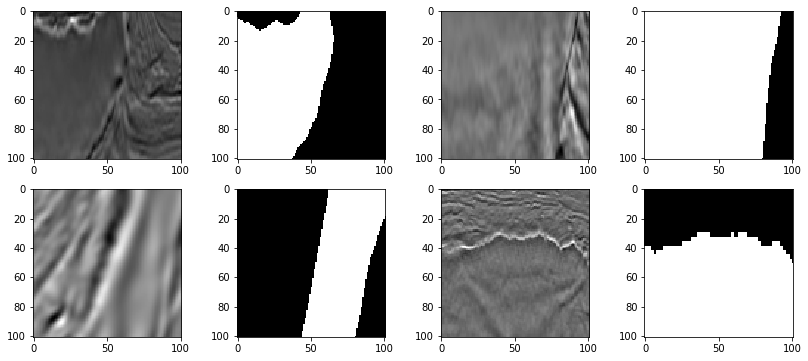

In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[15,511,1130,3452]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  ax[l[0]][l[1]].imshow( cv2.imread(X[index]) )
  ax[l[0]][l[1]+1].imshow( cv2.imread(Y[index]) )

In [0]:
from skimage.transform import resize

img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [5]:
all_images = glob.glob('masks/*')
print(len(all_images), X.shape)

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, array_to_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

IMG_DIM = (128,128,3)

X = np.array([ upsample(img_to_array( load_img(file, color_mode='grayscale') )) for file in X.values ])
Y = np.array([ upsample(img_to_array( load_img(file, color_mode='grayscale' ) )) for file in Y.values ])/255

X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2, stratify=LabelEncoder().fit_transform(pd.qcut(Z,5)))
del X,Y; gc.collect()

X_train = np.append( X_train, [ np.fliplr(x) for x in X_train ], axis=0 )
#X = np.append( X, [ np.flipud(x) for x in X ], axis=0 )
Y_train = np.append( Y_train, [ np.fliplr(y) for y in Y_train ], axis=0 )
#Y = np.append( Y, [ np.flipud(y) for y in Y ], axis=0 )

X_train = np.repeat(X_train,3,axis=3)
X_val = np.repeat(X_val,3,axis=3)

print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)

4000 (4000,)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(6400, 128, 128, 3) (6400, 128, 128, 1) (800, 128, 128, 3) (800, 128, 128, 1)


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   brightness_range=(0.9,1.1),
                                   zoom_range=[.95,1.05], 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

### Implementing a Fully Convolutional Network called UNET for Image Segmentation

In [0]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [25]:
from keras import optimizers
from uresnet import UResNet34
unet = UResNet34(input_shape=(128,128,3), resnet_untrainable = 1 )


def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)


unet.compile(optimizer=optimizers.Adam(lr=1e-3), loss=bce_dice_loss, metrics=['accuracy',my_iou_metric])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in unet.layers]
temp = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
temp[temp['Layer Trainable']]
pass

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, 
                                    monitor='val_my_iou_metric', mode='max', verbose=0)
early_stopping = EarlyStopping(monitor='val_my_iou_metric', patience=10, mode='max')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_my_iou_metric',min_lr=1e-4, mode='max')

callback_list = [model_checkpoint, early_stopping, reduceLR]

history = unet.fit_generator(train_generator, steps_per_epoch=50, epochs=150,
                              validation_data=val_generator, validation_steps=10, 
                              verbose=2,callbacks=callback_list)

unet = load_model('model_best_checkpoint.h5')

Epoch 1/150
 - 17s - loss: 1.0774 - acc: 0.7620 - my_iou_metric: 0.3543 - val_loss: 1.3941 - val_acc: 0.7614 - val_my_iou_metric: 0.4281
Epoch 2/150
 - 6s - loss: 0.7182 - acc: 0.8691 - my_iou_metric: 0.4921 - val_loss: 1.5717 - val_acc: 0.7546 - val_my_iou_metric: 0.4062
Epoch 3/150
 - 7s - loss: 0.6161 - acc: 0.8785 - my_iou_metric: 0.5202 - val_loss: 2.6032 - val_acc: 0.7342 - val_my_iou_metric: 0.3438
Epoch 4/150
 - 7s - loss: 0.5010 - acc: 0.8992 - my_iou_metric: 0.5666 - val_loss: 2.5347 - val_acc: 0.7298 - val_my_iou_metric: 0.3531
Epoch 5/150
 - 7s - loss: 0.5827 - acc: 0.8940 - my_iou_metric: 0.5544 - val_loss: 2.5635 - val_acc: 0.7445 - val_my_iou_metric: 0.3688

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/150
 - 7s - loss: 0.4849 - acc: 0.9030 - my_iou_metric: 0.6092 - val_loss: 3.2409 - val_acc: 0.7378 - val_my_iou_metric: 0.3875
Epoch 7/150
 - 7s - loss: 0.4593 - acc: 0.9083 - my_iou_metric: 0.6139 - val_loss: 2.9289 - val_acc: 

KeyboardInterrupt: ignored

### Model Performance
1. Loss : 0.14
2. Acc : 0.94

NameError: ignored

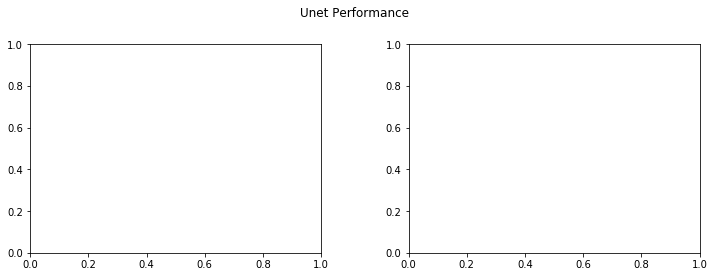

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)


epoch_list = history.epoch
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
l2 = ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

In [11]:
del X_train, Y_train, X_val, Y_val; gc.collect()

510

## To Submit

In [0]:
from keras.models import load_model
#unet = load_model('model_best_checkpoint.h5')

In [10]:
submission = pd.read_csv('sample_submission.csv',usecols=['id'])
submission.head()

,id
0,155410d6fa
1,78b32781d1
2,63db2a476a
3,17bfcdb967
4,7ea0fd3c88


In [0]:
outputs = [ 'images/{}.png'.format(i) for i in submission.id.values ]
outputs = np.array([ upsample(img_to_array( load_img(file) )) for file in outputs ])
outputs = np.array(outputs)
outputs = unet.predict(outputs)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
threshold_best = 0.1

def process_output(out):
  im = downsample(out)
  im = (im>threshold_best)*1
  return np.squeeze(im)

def rle_encode(im):
  im = im.T
  im = np.reshape(im,(101*101))
  pixels = im.flatten(order = 'F')
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


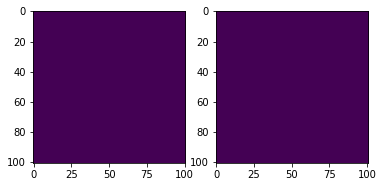

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
im = downsample(outputs[456])
im = (np.squeeze(im)>threshold_best)*1
ax1.imshow(im)
im = rle_encode(im)
im = rle_to_output(im)
ax2.imshow(im)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


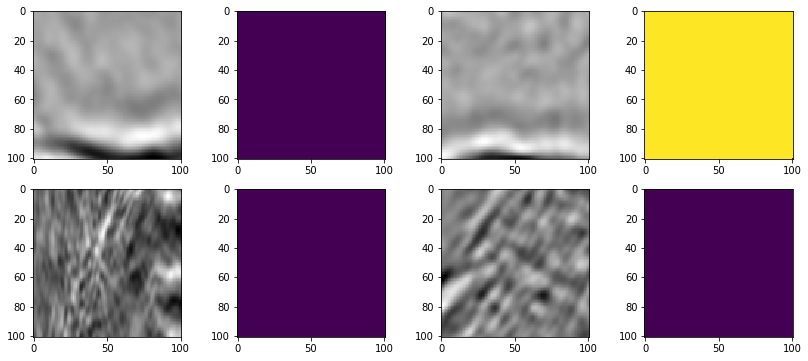

In [30]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[145,678,1456,13453]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  im = cv2.imread("images/{}.png".format(submission.iloc[index].id))
  ax[l[0]][l[1]].imshow(im)
  ax[l[0]][l[1]+1].imshow(process_output(outputs[index]))

Text(0.5, 1.0, 'Predicted')

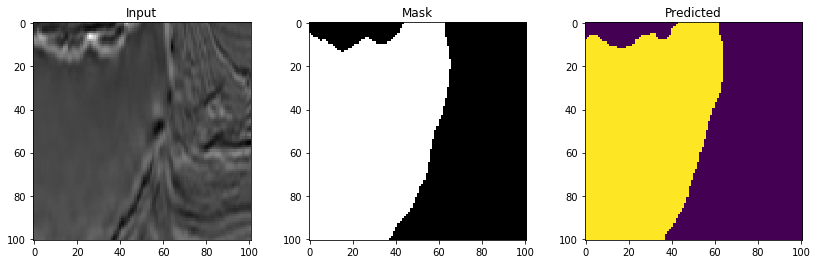

In [62]:
index=15
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(14,4))
img = np.array([ img_to_array( load_img('images/'+data.iloc[index].id+'.png', target_size = IMG_DIM, color_mode='grayscale' ) ) ])/255
temp = np.zeros((1,128,128,1))
temp = unet.predict(img)
ax[0].imshow(cv2.imread('images/'+data.iloc[index].id+'.png'));ax[0].set_title('Input')
ax[1].imshow(cv2.imread('masks/'+data.iloc[index].id+'.png'));ax[1].set_title('Mask')
ax[2].imshow(process_output(temp[0]),label="Predicted");ax[2].set_title('Predicted')

In [63]:
submission['rle_mask'] = [ rle_encode(process_output(o)) for o in outputs ]
submission.head()

,id,rle_mask
0,155410d6fa,3 96 104 2 133 65 205 92 306 94 407 94 508 94 ...
1,78b32781d1,3 5 15 10 42 5 59 20 81 1 85 1 88 2 91 4 96 5 ...
2,63db2a476a,3 2 50 1 52 2 60 1 67 2 80 3 91 1 97 1 99 2 10...
3,17bfcdb967,7 3 23 1 26 1 31 4 56 1 61 1 64 1 82 1 89 6 99...
4,7ea0fd3c88,3 22 28 9 39 16 58 6 82 13 96 1 99 1 104 4 113...


In [0]:
submission.to_csv('submission.csv',index=False)

In [65]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "5. aug(lr,ud)+(0.5)"

100% 33.9M/33.9M [00:01<00:00, 34.9MB/s]
Successfully submitted to TGS Salt Identification Challenge

In [0]:
callback_list = [model_checkpoint,early_stopping, reduceLR]
histories = []
i=1
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=5,)
for train_index, test_index in skf.split(X, LabelEncoder().fit_transform(pd.qcut(Z,5))):
      train_generator = train_datagen.flow(X[train_index], Y[train_index], batch_size=24)
      val_generator = val_datagen.flow(X[test_index], Y[test_index], batch_size=24)
      print("----------------------------------Training {} UNET------------------------------".format(i))
      history = unets[i-1].fit_generator(train_generator, steps_per_epoch=25, epochs=150,
                              validation_data=val_generator, validation_steps=20, 
                              verbose=2,callbacks=callback_list)
      unets[i-1] = load_model('model_best_checkpoint.h5')
      histories.append(history)
      i+=1